# Hierarchical Clustering of Languages

In [1]:
from typing import Sequence
from statistics import mean

import pandas as pd
import seaborn as sns

### 1. Load the data

In [2]:
df = pd.read_csv(r"/home/kristian/Downloads/languages.csv")

In [3]:
df.shape  # rows, columns

(21, 12)

In [4]:
# convert everything to lower case
for col in df:
    df[col] = df[col].str.lower()
df.head(3)

,english,german,polish,Kannada,Tamil,russian,mandarin,Spanish,Hindi,Marathi,Telugu,Azerbaijani
0,cat,katze,kot,bekku,poonai,kot,māo,gato,billi,manzar,pilli,pishik
1,dog,hund,pies,naayi,naayi,sobaka,gǒu,perro,kutta,kutreya,kukka,it
2,house,haus,dom,mane,veedu,dom,jia,casa,ghar,ghar,illu,ev


In [5]:
# df.isna().sum().plot.bar()  # visualize empty values
# df.fillna("", inplace=True) # problematic because of zero division
df.dropna(inplace=True)
df.shape

(18, 12)

In [6]:
# df.info()

### 2. Similarity of words

In [7]:
def calc_word_similarity(word1: str, word2: str) -> float:
    """a simple measure for word similarity between 0 and 1"""
    s1, s2 = set(word1), set(word2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [8]:
calc_word_similarity("hello", "hello")

1.0

In [9]:
assert calc_word_similarity("hello", "hello") == 1.0
assert calc_word_similarity("sun", "moon") == 0.2
assert calc_word_similarity("cat", "dog") == 0.0

### 3. Similarity of languages

In [10]:
def calc_language_similarity(
        words1: Sequence[str],
        words2: Sequence[str]
    ) -> float:
    """average of the word similarity between 0 and 1"""
    word_sims = []
    for w1, w2 in zip(words1, words2):
        sim = calc_word_similarity(w1, w2)
        word_sims.append(sim)
    return mean(word_sims)

In [11]:
# list(zip("ABC", "DEFG"))

In [12]:
assert calc_language_similarity(
    ["hello", "sun", "cat"],
    ["hello", "moon", "dog"],
) == 0.4

In [13]:
df.columns

Index(['english', 'german', 'polish', 'Kannada', 'Tamil', 'russian',
       'mandarin', 'Spanish', 'Hindi', 'Marathi', 'Telugu', 'Azerbaijani'],
      dtype='object')

In [14]:
calc_language_similarity(df["Tamil"], df["Azerbaijani"])

0.22526855860189193

In [15]:
calc_language_similarity(df["polish"], df["russian"])

0.5787277537277538

### 4. Similarity matrix

In [16]:
languages = df.columns

sims = []
for lang1 in languages:
    row = []
    for lang2 in languages:
        sim = calc_language_similarity(df[lang1], df[lang2])
        row.append(sim)
    sims.append(row)

In [17]:
sim_matrix = pd.DataFrame(sims, index=languages, columns=languages)
perc = (sim_matrix * 10).round().astype(int)
perc

,english,german,polish,Kannada,Tamil,russian,mandarin,Spanish,Hindi,Marathi,Telugu,Azerbaijani
english,10,6,3,2,1,3,1,4,2,2,2,3
german,6,10,3,2,1,3,1,4,3,2,2,3
polish,3,3,10,2,2,6,1,3,2,1,2,3
Kannada,2,2,2,10,4,3,1,3,4,5,4,2
Tamil,1,1,2,4,10,3,2,2,2,3,4,2
russian,3,3,6,3,3,10,1,3,2,2,3,4
mandarin,1,1,1,1,2,1,10,1,1,1,1,1
Spanish,4,4,3,3,2,3,1,10,2,3,2,2
Hindi,2,3,2,4,2,2,1,2,10,4,4,2
Marathi,2,2,1,5,3,2,1,3,4,10,4,2


<AxesSubplot: >

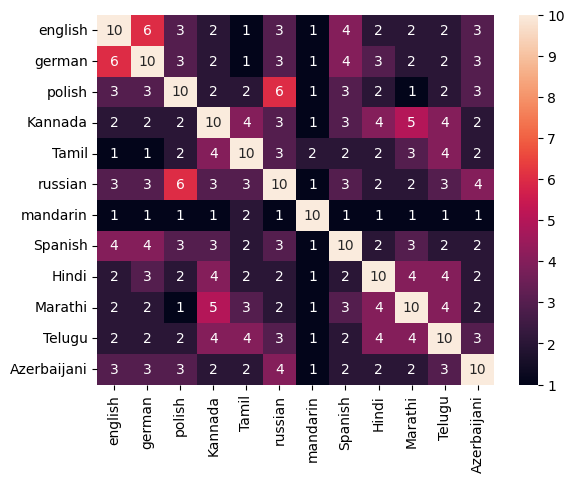

In [18]:
sns.heatmap(perc, annot=True)

### 5. Tree data structure

In [19]:
from dataclasses import dataclass

@dataclass
class LeafNode:

    name: str
    words: Sequence[str]
        
    def draw(self, graph):
        graph.node(self.name, self.name)


@dataclass
class InternalNode:

    name: str
    left: LeafNode
    right: LeafNode
        
    def draw(self, graph):
        self.left.draw(graph)
        self.right.draw(graph)
        graph.node(self.name, '', shape='point')
        graph.edge(self.name, self.left.name, dir='none')
        graph.edge(self.name, self.right.name, dir='none')

### 6. Hierarchical Clustering

In [20]:
def calc_node_similarity(node1, node2):
    """implements the linkage rule for joining internal nodes"""
    if type(node1) == LeafNode and type(node2) == LeafNode:
        return calc_language_similarity(node1.words, node2.words)
    elif type(node1) == InternalNode and type(node2) == LeafNode:
        # linkage rule: mean similarity
        return (
            calc_node_similarity(node2, node1.left) +
            calc_node_similarity(node2, node1.right)
        ) / 2
    else:
        return (
            calc_node_similarity(node1, node2.left) +
            calc_node_similarity(node1, node2.right)
        ) / 2

In [21]:
def find_best_similarity(nodes):
    best_sim = -1.0
    best_nodes = None

    for node1 in nodes:
        for node2 in nodes:
            if node1 == node2: continue # skip the diagonal
            sim = calc_node_similarity(node1, node2)
            if sim > best_sim:
                best_sim = sim
                best_nodes = node1, node2
    
    return best_nodes

In [22]:
# 1. create a leaf node for every element of E.
nodes = [LeafNode(lang, df[lang]) for lang in df.columns]

while len(nodes) > 1:
    # 2. find the pair of most similar elements (e1, e2) in E
    n1, n2 = find_best_similarity(nodes)

    # 3. create a new internal node that contains e1 and e2
    internal = InternalNode(
        name=f"[{n1.name}-{n2.name}]",
        left=n1,
        right=n2,
    )

    # 4. add the new node to E
    nodes.append(internal)

    # 5. remove e1 and e2 from E
    nodes.remove(n1)
    nodes.remove(n2)

    # 6. repeat from step 2. until there is only one node in E
    # (see above)
    print(internal.name)

[english-german]
[polish-russian]
[Kannada-Marathi]
[Hindi-Telugu]
[Spanish-[english-german]]
[[Kannada-Marathi]-[Hindi-Telugu]]
[Tamil-[[Kannada-Marathi]-[Hindi-Telugu]]]
[Azerbaijani-[polish-russian]]
[[Spanish-[english-german]]-[Azerbaijani-[polish-russian]]]
[[Tamil-[[Kannada-Marathi]-[Hindi-Telugu]]]-[[Spanish-[english-german]]-[Azerbaijani-[polish-russian]]]]
[mandarin-[[Tamil-[[Kannada-Marathi]-[Hindi-Telugu]]]-[[Spanish-[english-german]]-[Azerbaijani-[polish-russian]]]]]


### 7. Draw the tree

In [23]:
from graphviz import Digraph

def draw_tree(nodes):
    """uses Graphviz to draw a tree on screen"""
    tree = nodes[0]
    graph = Digraph(
        edge_attr={'dir': 'back', 'color': 'black'},
        node_attr={'fontname': 'arial', 
                   'color': 'lightblue',
                   'style': 'filled'}
    )
    tree.draw(graph)
    graph.render('languages.gv', view=True)

In [24]:
draw_tree(nodes)